# AlexNet
- Cifar10
- Notebooks@Azure
- Python 3.8.5
- 仅使用d2l库用于创建图表
- 引入BatchNormlization并激活Relu函数
- 定义了`forward()`函数，用于计算模型的前向传播。
- 在分类器部分实现了全连接层ReLU激活函数和Dropout层
- 使用Adabound优化器、余弦退火学习率调度器、权重衰减
- 交叉熵损失函数
- Cuda加速
- 使用Pytorch、Torchvision内置方法加载数据集
- 使用sklearn.metrics模块获得测试准确率和F1得分
- 使用自定义的train()函数
- 为什么要重写Train():
    d2l中内置的train_ch13已经能满足需求但是没法再堆叠打印出F1得分并且trainloss在过程中一直是趋近于0不符合实际我觉得存在bug并且使用自定义的Train()可以更自由的调节lr，在需要查看整个过程中的数据在GoogleNet中可以查看所有的数据做出更精细化的调整
----

#### 模型介绍
- 包含的主要部分：特征提取器（features）和分类器（classifier）以及网络的前向传播（forward）方法。

* 特征提取器（features）部分包括一系列的卷积层（Conv2d）、批归一化层（BatchNorm2d）、ReLU激活函数和最大池化层（MaxPool2d）。这些层的作用是逐步从输入图像中提取有用的特征。

* 分类器（classifier）部分是一个全连接层（Linear）的序列，其中包括ReLU激活函数和Dropout层。它将通过特征提取器提取的特征进行展平（flatten）操作，然后通过全连接层进行分类预测。

* 在网络的前向传播（forward）方法中，输入数据将通过特征提取器部分进行特征提取，然后通过展平操作将特征展平为一维张量。最后，展平后的特征将通过分类器部分进行分类预测，并返回预测结果。

#### 数据增强
- 从输入图像中随机裁剪一个大小为 32x32 的部分，并进行 4 像素的填充。
- 以 0.5 的概率随机水平翻转图像。
- 通过减去每个通道的均值并除以标准差值，对张量图像进行归一化。提供的均值和标准差值对应于 CIFAR-10 数据集的 RGB 通道。
- 对图像进行随机裁剪并缩放到指定的尺寸。
- 对图像进行随机的颜色调整。
- 对图像进行随机旋转。
- 另外，我注意到过强的数据增强对于cifar10数据集而言并无很强的作用，收益与付出严重不成比例，在模型的训练过程中，设备花费了大量的时间在数据增强上,但对于 CIFAR-10 数据集，由于图像的尺寸较小（`32x32pixel`），数据增强的效果可能相对较小，因为已经包含了一定的多样性。因此，在我看来对 CIFAR-10 数据集应用数据增强可能不是必需的，在稍后的Vgg11、GoogleNet、ResNet18中我取消了图像的随机裁剪、随机颜色调整、随机旋转。

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from adabound import AdaBound
import  d2l
from sklearn.metrics import accuracy_score, f1_score
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


In [12]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x




In [13]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.8, 1.2)),  # 随机裁剪并缩放到指定尺寸，尺度和长宽比随机变化
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 随机调整亮度、对比度、饱和度和色调
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=15),  # 随机旋转角度范围为 -30 到 30 度之间
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

batch_size = 128#批量大小
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)#加载CIFAR-10数据集，如果数据集不存在则会下载到./data文件夹下
train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=5)#对训练集进行数据预处理，transform_train是一个由多个数据处理操作组成的Pipeline
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)#对测试集进行数据预处理
test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=5)#

Files already downloaded and verified
Files already downloaded and verified


In [14]:
net = AlexNet()
net = net.to(device)

Epoch [100/100], Train Loss: 0.0291, Train Acc: 0.9911, Train F1: 0.9907, Test Loss: 0.3101, Test Acc: 0.9298, Test F1: 0.9250


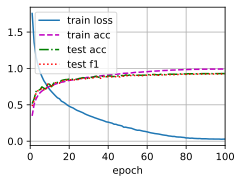

In [15]:
num_epochs = 100
optimizer = AdaBound(net.parameters(), lr=0.00001, final_lr=0.1,weight_decay=5e-4)#使用adabound优化器，效果更好，但是训练时间更长，需要更多的epoch，lr也要小一些，final_lr也要小一些
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)#学习率调整策略
criterion = nn.CrossEntropyLoss()

def train(net, trainloader, testloader, num_epochs, optimizer, criterion, device, scheduler=None):
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc', 'test f1'])
    for epoch in range(num_epochs):
        net.train()  # 将模型设置为训练模式
        train_loss, train_acc, train_f1 = 0.0, 0.0, 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy())
            train_f1 += f1_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy(), average='macro')
        train_loss /= len(trainloader)
        train_acc /= len(trainloader)
        train_f1 /= len(trainloader)
        # 在测试集上验证模型性能
        net.eval()  # 将模型设置为评估模式
        test_loss, test_acc, test_f1 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                test_acc += accuracy_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy())
                test_f1 += f1_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy(), average='macro')

        test_loss /= len(testloader)
        test_acc /= len(testloader)
        test_f1 /= len(testloader)

        # 输出每个 epoch 的结果
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))

        if scheduler:
            if scheduler.__module__ == 'torch.optim.lr_scheduler':
                # 使用 PyTorch 内置的学习率调度器
                scheduler.step()
            else:
                # 使用自定义的学习率调度器
                for param_group in optimizer.param_groups:
                    param_group['lr'] = scheduler(epoch)

        animator.add(epoch+1, (train_loss, train_acc, test_acc, test_f1))
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))
train(net, train_iter, test_iter, num_epochs, optimizer, criterion, device, scheduler)

#### train( )函数
`train()`函数是一个基于PyTorch的函数，用于训练神经网络模型。它需要以下参数：
* `net`： 要训练的神经网络模型。
* `trainloader`： 训练数据加载器。
* `testloader`： 测试数据加载器。
* `num_epochs`： 训练的历时数。
* `optimizer`： 训练时使用的优化器。
* `criterion`： 训练中使用的损失函数。
* `device`： 训练模型的设备（CPU或GPU）。
* `scheduler`： 学习率调度器（可选）。

函数首先调用 `d2l`中`Animator`类创建一个对象来绘制图像跟踪训练的进展。然后，进入一个指定的轮数的循环。在每轮中，该函数做以下工作：

1. 将模型设置为训练模式。
2. 遍历训练数据加载器，对每批数据进行前向传递和后向传递。
3. 使用优化器更新模型参数。
4. 计算训练损失和准确性。
5. 在测试数据上评估模型，并计算测试损失和准确性。
6. 将所得的损失和准确率在图像中更新

若使用了一个学习率调度器，`train`函数将在每个历时结束时更新学习率。

`train()`函数打印出训练损失和准确率，以及测试损失和准确率。

### Result
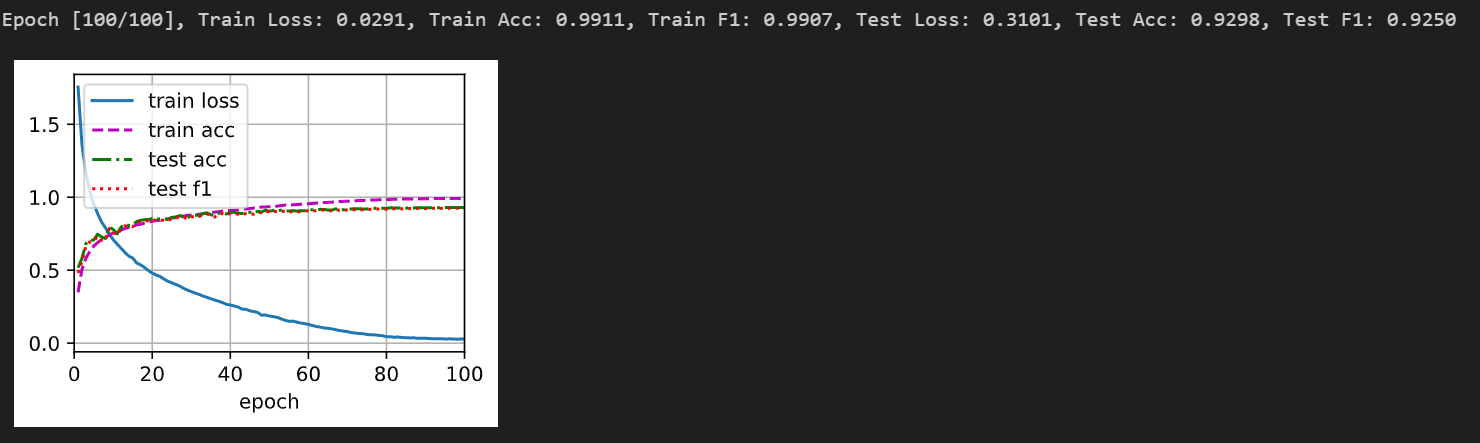
>Epoch [100/100], Train Loss: 0.0291, Train Acc: 0.9911, Test Loss: 0.3101, Test Acc: 0.9298

#### 参数说明
参数说明如下：

- Learning Rate（学习率）：0.00001。adabound优化器在尽量小的学习率下表现良好。
- final Lr(最终学习率) : 0.1

- Batch Size（批大小）：128。

- Epochs（训练轮数）：100。

- Dropout：0.5。 Dropout 为 0.5，在训练过程中每个神经元的输出有 50% 的概率被置为零。

- Weight Decay（权重衰减）：5e-4。

- Momentum（动量）：0.9。动量系数为 0.9，当前的梯度更新方向受到 90% 的动量影响。